# Data Wrangling and Transformation of Nested JSON-like Data for Analysis


In [1]:
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

# Reading all cities' Excel files

df_hyderabad = pd.read_excel("hyderabad_cars.xlsx")  # Reading Hyderabad cars data
df_hyderabad['Location'] = 'Hyderabad'  # Adding a 'Location' column to identify the city

df_bangalore = pd.read_excel("bangalore_cars.xlsx")  # Reading Bangalore cars data
df_bangalore['Location'] = 'Bangalore'  # Adding 'Location' column for Bangalore

df_chennai = pd.read_excel("chennai_cars.xlsx")  # Reading Chennai cars data
df_chennai['Location'] = 'Chennai'  # Adding 'Location' column for Chennai

df_kolkata = pd.read_excel("kolkata_cars.xlsx")  # Reading Kolkata cars data
df_kolkata['Location'] = 'Kolkata'  # Adding 'Location' column for Kolkata

df_delhi = pd.read_excel("delhi_cars.xlsx")  # Reading Delhi cars data
df_delhi['Location'] = 'Delhi'  # Adding 'Location' column for Delhi

df_jaipur = pd.read_excel("jaipur_cars.xlsx")  # Reading Jaipur cars data
df_jaipur['Location'] = 'Jaipur'  # Adding 'Location' column for Jaipur

# Merging all individual city dataframes into a single dataframe using pd.concat()
# axis=0 means we are stacking the dataframes vertically (i.e., adding rows)
# reset_index(drop=True) resets the index after merging, avoiding duplicate or non-sequential indexes
merged_df = pd.concat([df_hyderabad, df_bangalore, df_chennai, df_kolkata, df_delhi, df_jaipur], axis=0).reset_index(drop=True)

# Displaying the first row of the merged dataframe to verify that data has been merged correctly
merged_df.head(1)


,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links,Location
0,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...,Hyderabad


In [3]:
# Dropped the 'car_links' column as it contains irrelevant data for analysis
merged_df = merged_df.drop(['car_links'], axis=1)

# ast.literal_eval safely evaluates a string containing Python literals (like numbers, lists, dictionaries) 
# and converts them into their corresponding data types (e.g., converting strings that represent dictionaries back into dictionaries).
# Here, we apply it to columns that store string representations of dictionaries, to convert them into actual dictionaries.

merged_df['new_car_detail'] = merged_df['new_car_detail'].apply(ast.literal_eval)  # Convert 'new_car_detail' strings to dicts
merged_df['new_car_overview'] = merged_df['new_car_overview'].apply(ast.literal_eval)  # Convert 'new_car_overview' strings to dicts
merged_df['new_car_feature'] = merged_df['new_car_feature'].apply(ast.literal_eval)  # Convert 'new_car_feature' strings to dicts
merged_df['new_car_specs'] = merged_df['new_car_specs'].apply(ast.literal_eval)  # Convert 'new_car_specs' strings to dicts

# Displaying the first value from the 'new_car_specs' column to inspect the structure of the nested dictionary.
# The goal is to extract data from 'top' and 'list' keys in this column.
merged_df['new_car_specs'][0]

# Displaying the first value from the 'new_car_overview' column to inspect the structure of the nested dictionary.
# We want to extract data from the 'top' key and any nested keys within it.
merged_df['new_car_overview'][0]

# Displaying the first value from the 'new_car_feature' column to inspect the structure of the nested dictionary.
# We aim to extract data from the 'top' and 'data' keys in this column.
merged_df['new_car_feature'][0]

# pd.json_normalize is used to flatten nested JSON-like data into a flat table format (DataFrame),
# expanding all the nested structures into separate columns for easier analysis.
# Here, we apply it to the 'new_car_detail' column to unpack the nested dictionary into individual columns.
details_unpacked = pd.json_normalize(merged_df['new_car_detail'])

# Displaying the first row of the unpacked 'details_unpacked' DataFrame to verify the flattened structure
details_unpacked.head(1)


,it,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,centralVariantId,variantName,price,priceActual,priceSaving,priceFixedText,trendingText.imgUrl,trendingText.heading,trendingText.desc
0,0,Petrol,Hatchback,"20,000",Automatic,1,1st Owner,Volkswagen,Volkswagen Polo,2022,7746,1.0 TSI Highline Plus AT,₹ 10.44 Lakh,,,None,https://stimg.cardekho.com/used-cars/common/ic...,Trending Car!,High chances of sale in next 6 days


In [5]:
# Function to extract key-value pairs from 'top' in 'new_car_overview'
def process_row(row):
    row_data = {item['key']: item['value'] for item in row['top']}
    return row_data

# Apply the function to unpack 'new_car_overview' and convert to DataFrame
overview_unpacked = merged_df['new_car_overview'].apply(lambda row: pd.Series(process_row(row)))

# Display the first row of the unpacked DataFrame
overview_unpacked.head(1)


,Registration Year,Insurance Validity,Fuel Type,Seats,Kms Driven,RTO,Ownership,Engine Displacement,Transmission,Year of Manufacture
0,2022,Third Party insurance,Petrol,5 Seats,"20,000 Kms",TS04,First Owner,999 cc,Automatic,2022.0


In [7]:
# Function to extract 'top' and 'data' values from 'new_car_feature'
def process_features(row):
    features = {}
    
    # Flatten 'top' values
    for item in row['top']:
        features[item['value']] = True
    
    # Flatten 'data' values
    for data_item in row.get('data', []):
        for sub_item in data_item.get('list', []):
            features[sub_item['value']] = True
    
    return features

# Apply function to unpack 'new_car_feature' and convert to DataFrame
features_unpacked = merged_df['new_car_feature'].apply(lambda row: pd.Series(process_features(row)))

# Display the first row of the unpacked DataFrame
features_unpacked.head(1)


,Power Steering,Power Windows Front,Air Conditioner,Heater,Adjustable Head Lights,Fog Lights Front,Anti Lock Braking System,Centeral Locking,Radio,Power Windows Rear,...,Roof Carrier,Blind Spot Monitor,Compass,Removable Convertible Top,Active Noise Cancellation,Heads Up Display,Cassette Player,Power Folding3rd Row Seat,Headlamp Washers,Smart Key Band
0,True,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Function to extract 'top' and 'data' values from 'new_car_specs'
def process_specifications(row):
    specs = {}

    # Flatten 'top' values
    for item in row['top']:
        specs[item['key']] = item['value']
    
    # Flatten 'data' values
    for data_item in row.get('data', []):
        for sub_item in data_item.get('list', []):
            specs[sub_item['key']] = sub_item['value']
    
    return specs

# Apply function to unpack 'new_car_specs' and convert to DataFrame
specs_unpacked = merged_df['new_car_specs'].apply(lambda row: pd.Series(process_specifications(row)))

# Display the first row of the unpacked DataFrame
specs_unpacked.head(1)

# Combine all unpacked DataFrames into a single DataFrame
combined_unpacked_df = pd.concat([details_unpacked, overview_unpacked, features_unpacked, specs_unpacked, merged_df['Location']], axis=1)

# Save the combined DataFrame to an Excel file
combined_unpacked_df.to_excel('combined_unpacked_df_full.xlsx', index=False)


# Data Preprocessing

In [18]:
# Load the combined unpacked DataFrame from the Excel file
df = pd.read_excel('combined_unpacked_df_full.xlsx')

# Display the first row of the DataFrame
df.head(1)

# Check the data types of each column in the DataFrame
df.dtypes


it                           int64
ft                          object
bt                          object
km                          object
transmission                object
                             ...  
Cargo Volumn                object
Top Speed                   object
Acceleration                object
Ground Clearance Unladen    object
Location                    object
Length: 243, dtype: object

In [20]:
# Remove columns where more than 50% of the data is missing
threshold = len(df) * 0.5
df.dropna(axis=1, thresh=threshold, inplace=True)

# Display the number of unique values per column
print(df.nunique())

# Remove columns that contain only a single unique value
df = df.loc[:, df.nunique() > 1]

# Check and remove duplicate rows
print(df.duplicated().sum())
df.drop_duplicates(keep='first', inplace=True)
print(df.duplicated().sum())

# Remove unnecessary columns
df.drop([
    'owner', 'centralVariantId', 'Fuel Type', 'Registration Year', 'Year of Manufacture',
    'Engine Displacement', 'Transmission', 'Max Power', 'Torque', 'Wheel Size', 'Seats.1',
    'Engine', 'Torque', 'Length', 'Width', 'Height', 'Wheel Base', 'Front Tread', 'Rear Tread',
    'Kerb Weight', 'Values per Cylinder', 'Value Configuration', 'Seats', 'Turning Radius',
    'Top Speed', 'Acceleration', 'Alloy Wheel Size', 'Kms Driven', 'Ownership', 'Max Torque',
    'Cargo Volumn'
], axis=1, inplace=True)

# Print the remaining column names
print(df.columns.tolist())

# Function to convert price from string to numerical
def convert_price(price_str):
    if isinstance(price_str, str):
        price_str = re.sub(r'[₹,]', '', price_str).strip()
        if 'Crore' in price_str:
            return float(price_str.replace('Crore', '').strip()) * 10000000
        elif 'Lakh' in price_str:
            return float(price_str.replace('Lakh', '').strip()) * 100000
        elif 'Thousand' in price_str:
            return float(price_str.replace('Thousand', '').strip()) * 1000
        else:
            return float(price_str)
    elif isinstance(price_str, (int, float)):
        return price_str
    else:
        return np.nan

# Apply the conversion function to the 'price' column
df['price'] = df['price'].apply(convert_price)

# Check for missing values in 'km' column
print(df['km'].isna().sum())

# Function to convert 'km' values to float after removing commas
def convert_km(km_str):
    km_str = re.sub(r',', '', km_str).strip()
    return float(km_str)

# Apply the conversion function to the 'km' column
df['km'] = df['km'].apply(convert_km)

# Function to clean and convert 'Mileage' values
def clean_mileage(value):
    if pd.isna(value):
        return np.nan
    value = str(value).strip().lower()
    if 'km/kg' in value:
        numeric_value = re.sub(r'[^\d.]', '', value).rstrip('.')
        return float(numeric_value) * 0.74
    else:
        numeric_value = re.sub(r'[^\d.]', '', value).rstrip('.')
        return float(numeric_value)

# Apply the cleaning function to the 'Mileage' column
df['Mileage'] = df['Mileage'].apply(clean_mileage)


it                    1
ft                    5
bt                   10
km                 4090
transmission          2
                   ... 
No Door Numbers       5
Cargo Volumn        321
Top Speed           305
Acceleration        332
Location              6
Length: 122, dtype: int64
85
0
['ft', 'bt', 'km', 'transmission', 'ownerNo', 'oem', 'model', 'modelYear', 'variantName', 'price', 'Insurance Validity', 'RTO', 'Mileage', 'Color', 'Engine Type', 'Displacement', 'No of Cylinder', 'Fuel Suppy System', 'Turbo Charger', 'Super Charger', 'Gear Box', 'Drive Type', 'Seating Capacity', 'Steering Type', 'Front Brake Type', 'Rear Brake Type', 'Tyre Type', 'No Door Numbers', 'Location']
0


In [22]:
# Filling null values in numerical columns using mean, median, or mode
df['Mileage'].fillna(df['Mileage'].mean().round(2), inplace=True)  # Fill missing 'Mileage' values with the mean
df['Displacement'].fillna(df['Displacement'].median(), inplace=True)  # Fill missing 'Displacement' values with the median
df['No of Cylinder'].fillna(df['No of Cylinder'].median(), inplace=True)  # Fill missing 'No of Cylinder' values with the median
df['Seating Capacity'].fillna(df['Seating Capacity'].mode()[0], inplace=True)  # Fill missing 'Seating Capacity' values with the mode
df['No Door Numbers'].fillna(df['Seating Capacity'].mode()[0], inplace=True)  # Fill missing 'No Door Numbers' values with the mode of 'Seating Capacity'

# Check the shape of the DataFrame after filling missing values
df.shape

# Check how many missing values remain in each column
df.isna().sum()


C:\Users\Anton\AppData\Local\Temp\ipykernel_6400\2774416734.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Mileage'].fillna(df['Mileage'].mean().round(2), inplace=True)  # Fill missing 'Mileage' values with the mean
C:\Users\Anton\AppData\Local\Temp\ipykernel_6400\2774416734.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

ft                       0
bt                       4
km                       0
transmission             0
ownerNo                  0
oem                      0
model                    0
modelYear                0
variantName              0
price                    0
Insurance Validity       4
RTO                    874
Mileage                  0
Color                    3
Engine Type            290
Displacement             0
No of Cylinder           0
Fuel Suppy System     1708
Turbo Charger         1029
Super Charger         1938
Gear Box               106
Drive Type            1540
Seating Capacity         0
Steering Type          254
Front Brake Type        96
Rear Brake Type         96
Tyre Type               77
No Door Numbers          0
Location                 0
dtype: int64

In [24]:
# Function to remove outliers from specified numerical columns using Z-scores
def remove_outliers(df, columns, z_thresh=3):
    for column in columns:
        # Calculate Z-scores for the column
        z_scores = stats.zscore(df[column])
        
        # Keep only rows where the absolute Z-score is below the threshold
        df = df[abs(z_scores) < z_thresh]
    
    return df

# Columns where outliers will be removed
columns_to_check = ['km', 'price', 'modelYear', 'Mileage', 'Displacement']

# Apply the outlier removal function
df_outliers_removed = remove_outliers(df, columns_to_check)

# Check the shape of the DataFrame after removing outliers
df_outliers_removed.shape


(7838, 29)

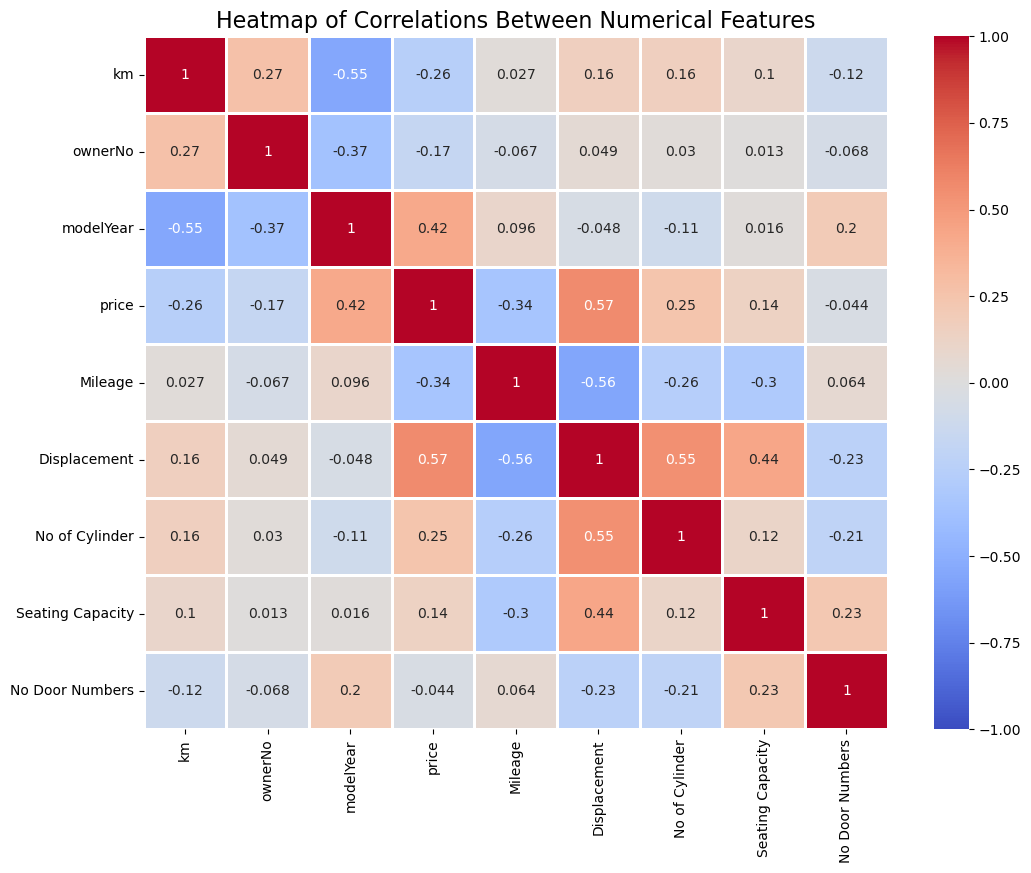

Correlation values with 'price':
km                 -0.256213
ownerNo            -0.169339
modelYear           0.421369
price               1.000000
Mileage            -0.343811
Displacement        0.565857
No of Cylinder      0.245100
Seating Capacity    0.137682
No Door Numbers    -0.043681
Name: price, dtype: float64


In [26]:
# Selecting only the numeric columns from the DataFrame
numeric_cols_df = df_outliers_removed.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix for the numeric columns
corr_matrix = numeric_cols_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linecolor='white', linewidths=1)  
plt.title('Heatmap of Correlations Between Numerical Features', fontsize=16)
plt.show()

# Extracting the correlation of each column with the 'price' column
price_corr = corr_matrix['price']

# Display the correlation values for 'price'
print("Correlation values with 'price':")
print(price_corr)


C:\Users\Anton\AppData\Local\Temp\ipykernel_6400\2311452310.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_corr.index, y=price_corr.values, palette='RdYlBu')  # Create a bar plot of correlations with 'price'


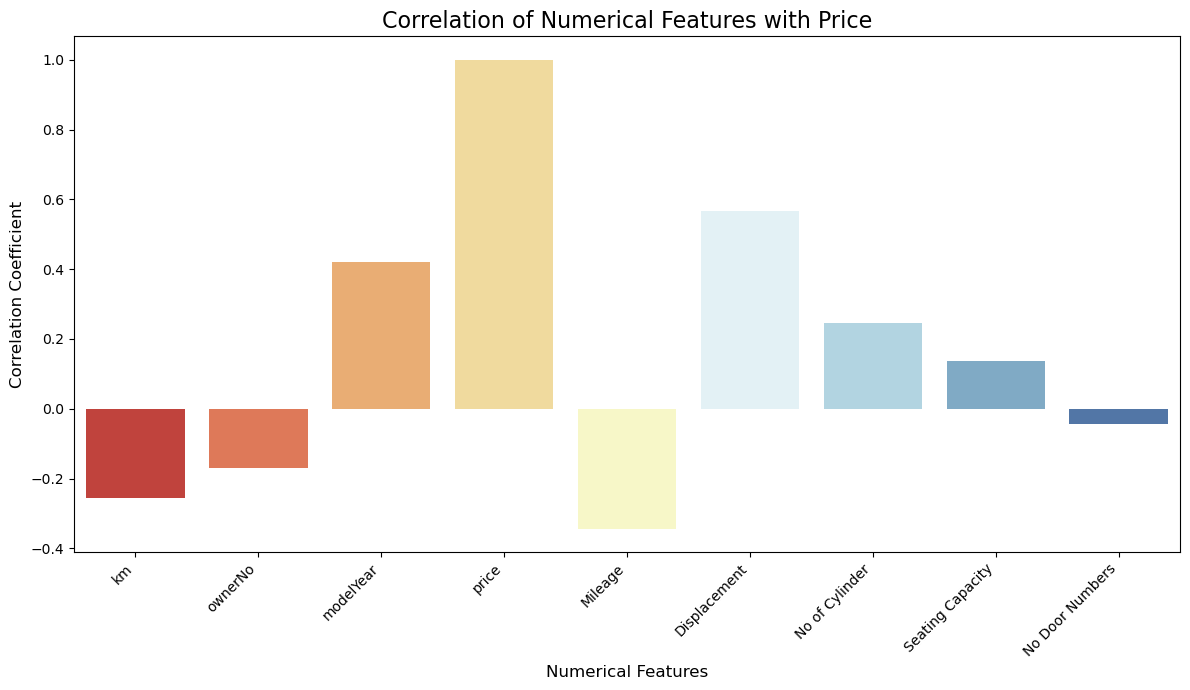

In [28]:
# Visualize the correlation of numerical columns with 'price' using a bar plot
plt.figure(figsize=(12, 7))  # Set the figure size
sns.barplot(x=price_corr.index, y=price_corr.values, palette='RdYlBu')  # Create a bar plot of correlations with 'price'
plt.title('Correlation of Numerical Features with Price', fontsize=16)  # Add a title
plt.xlabel('Numerical Features', fontsize=12)  # Label for x-axis
plt.ylabel('Correlation Coefficient', fontsize=12)  # Label for y-axis
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot


In [30]:
# The features 'modelYear', 'engine displacement', and 'km' show a strong correlation with 'price'
# 'Seating Capacity', 'No Door Numbers', and 'No of Cylinder' show little impact, so we drop these columns
df_outliers_removed.drop(['Seating Capacity', 'No Door Numbers', 'No of Cylinder'], axis=1, inplace=True)


In [32]:
# Display the first row of the updated DataFrame to verify the changes
df_outliers_removed.head(1)

# Get the count of unique values in the 'ft' (likely 'Fuel Type') column
df_outliers_removed['ft'].value_counts()


ft
Petrol    5360
Diesel    2394
Cng         68
Lpg         16
Name: count, dtype: int64

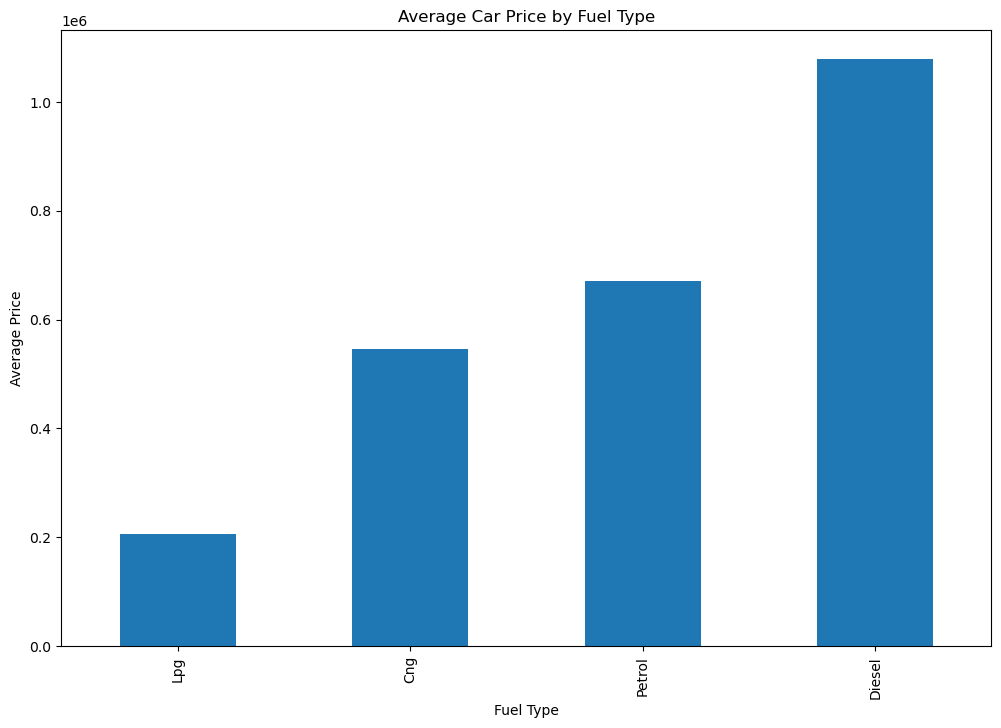

In [34]:
# Plot average car price by fuel type ('ft')
plt.figure(figsize=(12, 8))  # Set the figure size
average_prices = df_outliers_removed.groupby('ft')['price'].mean().sort_values()  # Calculate the average price by fuel type
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Car Price by Fuel Type')  # Add a title to the plot
plt.xlabel('Fuel Type')  # Label for the x-axis
plt.ylabel('Average Price')  # Label for the y-axis
plt.show()  # Display the plot


bt
Hatchback    3478
Sedan        2039
SUV          1958
MUV           331
Minivans       19
Other          10
Name: count, dtype: int64
3
0


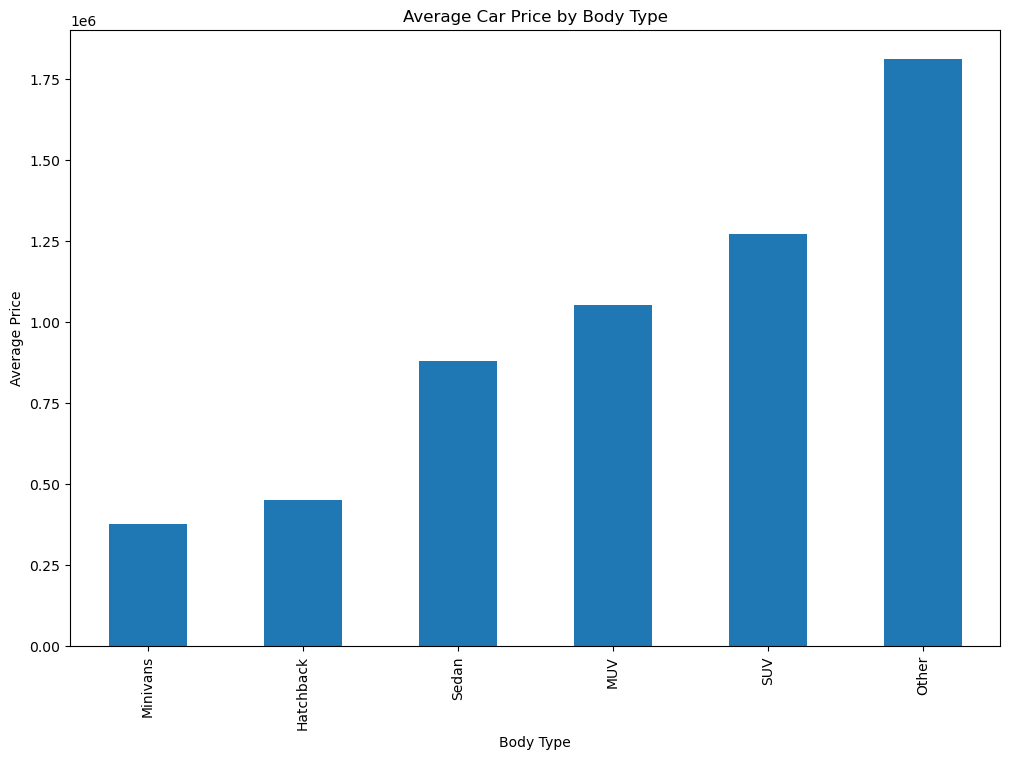

In [36]:
# Display the count of unique values in the 'bt' (likely 'Body Type') column
df_outliers_removed['bt'].value_counts()

# Combine specific categories into the 'Other' category
df_outliers_removed['bt'] = df_outliers_removed['bt'].replace('Pickup Trucks', 'Other')
df_outliers_removed['bt'] = df_outliers_removed['bt'].replace('Coupe', 'Other')
df_outliers_removed['bt'] = df_outliers_removed['bt'].replace('Convertibles', 'Other')
df_outliers_removed['bt'] = df_outliers_removed['bt'].replace('Wagon', 'Other')

# Verify the updated 'bt' column after combining categories
print(df_outliers_removed['bt'].value_counts())

# Check for missing values in the 'bt' column
print(df_outliers_removed['bt'].isna().sum())

# Drop rows where 'bt' has missing values
df_outliers_removed = df_outliers_removed.dropna(subset='bt')
print(df_outliers_removed['bt'].isna().sum())  # Verify no missing values in 'bt'

# Plot average car price by body type ('bt')
plt.figure(figsize=(12, 8))
average_prices = df_outliers_removed.groupby('bt')['price'].mean().sort_values()  # Calculate the average price by body type
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Car Price by Body Type')  # Add a title to the plot
plt.xlabel('Body Type')  # Label for the x-axis
plt.ylabel('Average Price')  # Label for the y-axis
plt.show()  # Display the plot


oem
Maruti           2169
Hyundai          1626
Honda             852
Tata              408
Mahindra          365
Renault           309
Volkswagen        286
Ford              283
Toyota            245
Skoda             158
Kia               155
Mercedes-Benz     151
Audi              129
BMW               122
Jeep              108
MG                 83
Nissan             78
Chevrolet          76
Datsun             74
Volvo              37
Fiat               30
Jaguar             25
Land Rover         22
Mini               11
Mitsubishi          9
Citroen             8
Name: count, dtype: int64


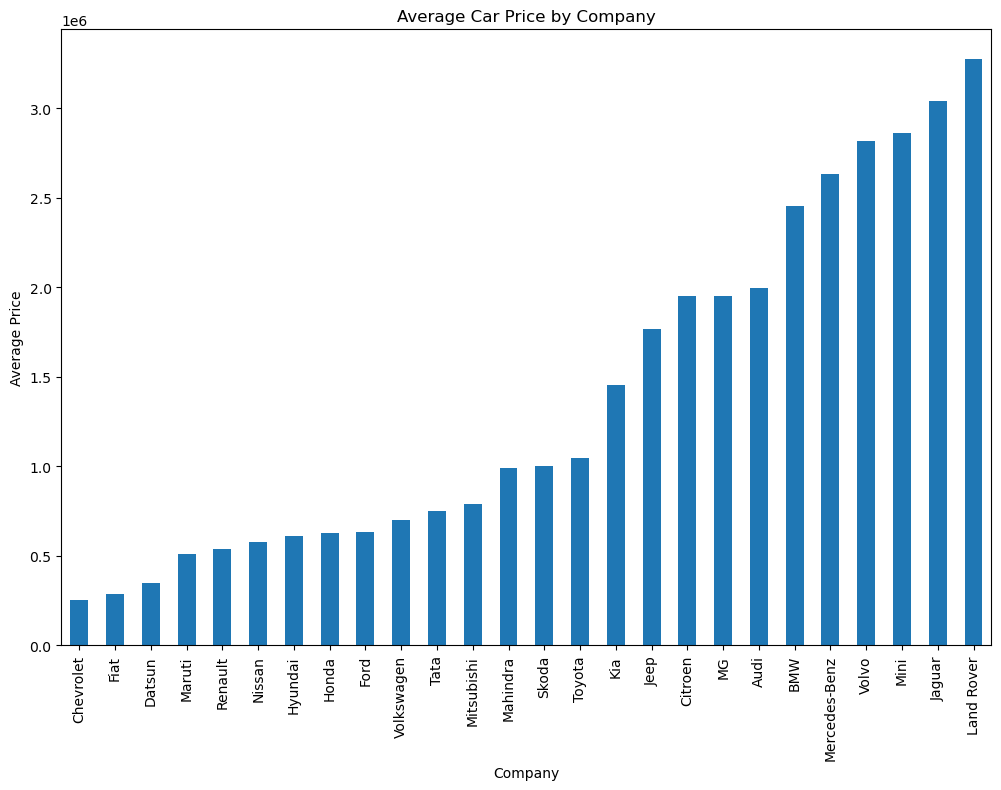

In [42]:
# Check the number of cars for each brand ('oem' column)
df_outliers_removed['oem'].value_counts() <= 5

# Drop rows where the brand ('oem') has less than 5 cars
oem_counts = df_outliers_removed['oem'].value_counts()
df_outliers_removed = df_outliers_removed[df_outliers_removed['oem'].map(oem_counts) > 5]

# Verify the updated 'oem' column after removing brands with less than 5 cars
print(df_outliers_removed['oem'].value_counts())

# Plot average car price by brand ('oem')
plt.figure(figsize=(12, 8))
average_prices = df_outliers_removed.groupby('oem')['price'].mean().sort_values()  # Calculate the average price by brand
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Car Price by Company')  # Add a title to the plot
plt.xlabel('Company')  # Label for the x-axis
plt.ylabel('Average Price')  # Label for the y-axis
plt.show()  # Display the plot

# Rename the 'oem' column to 'company'
df_outliers_removed.rename(columns={'oem': 'company'}, inplace=True)


In [44]:
# Check models with less than 10 cars listed
print(df_outliers_removed['model'].value_counts() < 10)

# Get the value counts of each model in the DataFrame
value_counts = df_outliers_removed['model'].value_counts()

# Convert the value counts into a new DataFrame
value_counts_df = value_counts.reset_index()

# Rename columns for clarity
value_counts_df.columns = ['model', 'count']

# Filter the DataFrame to include only models with less than 10 cars
filtered_value_counts_df = value_counts_df[value_counts_df['count'] < 10]

# Display the filtered models with less than 10 cars
print(filtered_value_counts_df)

# Sum of the counts of models that have less than 10 cars
filtered_value_counts_df['count'].sum()


model
Honda City              False
Maruti Swift            False
Hyundai i20             False
Maruti Baleno           False
Hyundai Grand i10       False
                        ...  
Mini 5 DOOR              True
Fiat Punto Pure          True
Volvo S 80               True
Tata Aria                True
Volkswagen CrossPolo     True
Name: count, Length: 254, dtype: bool
                    model  count
133             Volvo S60      9
134    Tata Safari Storme      9
135        Ford Freestyle      9
136           Skoda Laura      9
137        Chevrolet Sail      9
..                    ...    ...
249           Mini 5 DOOR      1
250       Fiat Punto Pure      1
251            Volvo S 80      1
252             Tata Aria      1
253  Volkswagen CrossPolo      1

[121 rows x 2 columns]


420

In [46]:
# Define the threshold for filtering models
threshold = 10

# Identify models with 10 or more cars and filter the DataFrame
categories_to_keep_model = value_counts[value_counts >= threshold].index
df_outliers_removed = df_outliers_removed[df_outliers_removed['model'].isin(categories_to_keep_model)]

# Display the shape of the filtered DataFrame (rows and columns)
print(df_outliers_removed.shape)

# Show the count of each model after filtering
df_outliers_removed['model'].value_counts()


(7399, 26)


model
Honda City                       363
Maruti Swift                     348
Hyundai i20                      328
Maruti Baleno                    292
Hyundai Grand i10                259
                                ... 
Mahindra Marazzo                  10
Mahindra XUV700                   10
MG Gloster                        10
Toyota Camry                      10
Land Rover Range Rover Evoque     10
Name: count, Length: 133, dtype: int64

In [48]:
# there are more than 250 models and many classes in Variant name,so we drop these.
df_outliers_removed.drop('variantName',axis=1,inplace=True)
df_outliers_removed['Insurance Validity'].value_counts()

Insurance Validity
Third Party insurance    3536
Comprehensive            2753
Third Party               609
Zero Dep                  289
Not Available             204
1                           3
2                           1
Name: count, dtype: int64

In [50]:
# Check the number of missing values in the 'Insurance Validity' column
print(df_outliers_removed['Insurance Validity'].isna().sum())

# Drop rows where 'Insurance Validity' is null
df_outliers_removed = df_outliers_removed.dropna(subset=['Insurance Validity'])

# Verify that there are no more missing values in 'Insurance Validity'
print(df_outliers_removed['Insurance Validity'].isna().sum())


4
0


C:\Users\Anton\AppData\Local\Temp\ipykernel_6400\2022659400.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_outliers_removed['Insurance Validity'].replace({'1': 'Not Available', '2': 'Not Available', 'Third Party': 'Third Party insurance'}, inplace=True)


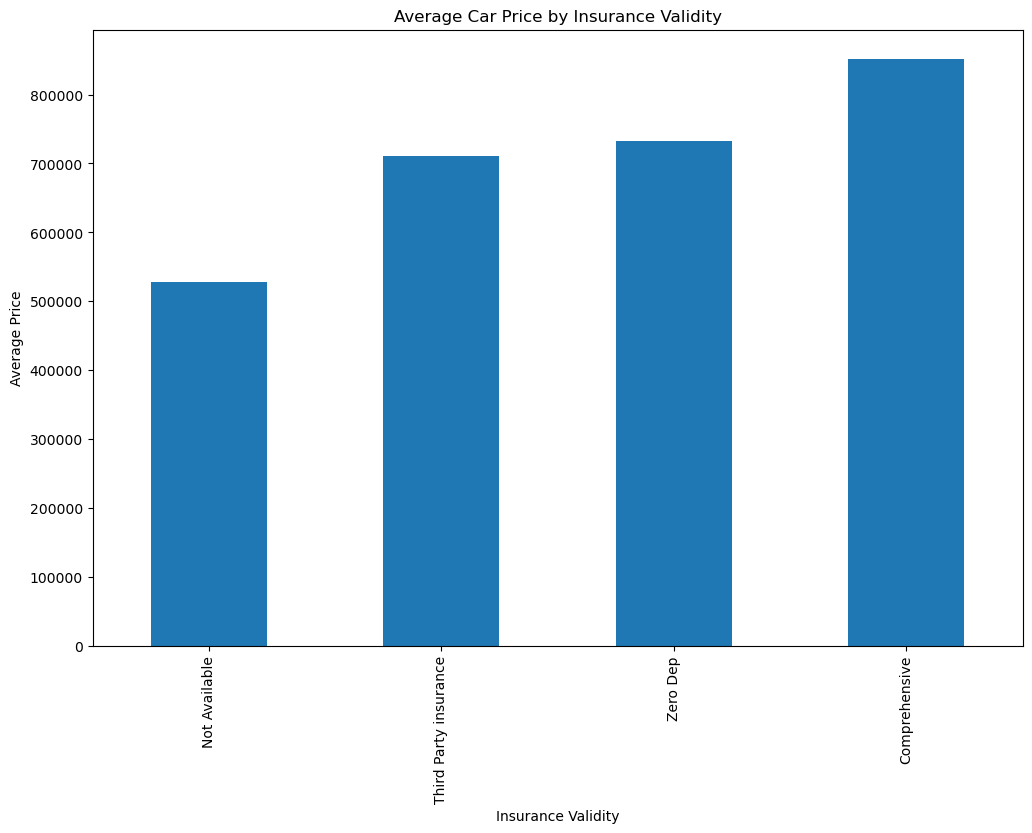

In [52]:
# Convert rows with values '1' and '2' to 'Not Available', and standardize 'Third Party' to 'Third Party insurance'
df_outliers_removed['Insurance Validity'].replace({'1': 'Not Available', '2': 'Not Available', 'Third Party': 'Third Party insurance'}, inplace=True)

# Plotting average car price by Insurance Validity
plt.figure(figsize=(12, 8))  # Set figure size
average_prices = df_outliers_removed.groupby('Insurance Validity')['price'].mean().sort_values()  # Calculate average price by Insurance Validity
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Car Price by Insurance Validity')  # Add a title
plt.xlabel('Insurance Validity')  # Label for x-axis
plt.ylabel('Average Price')  # Label for y-axis
plt.show()  # Display the plot


In [54]:
# Display the count of unique values in the 'RTO' column
print(df_outliers_removed['RTO'].value_counts())

# Check for missing values in the 'RTO' column
print(df_outliers_removed['RTO'].isna().sum())

# Mapping dictionary for RTO regions based on RTO codes
rto_region_mapping = {
    'KA': 'Karnataka',
    'HR': 'Haryana',
    'WB': 'West Bengal',
    'TN': 'Tamil Nadu',
    'UP': 'Uttar Pradesh',
    'DL': 'Delhi',
    'MH': 'Maharashtra',
    'RJ': 'Rajasthan',
    'AP': 'Andhra Pradesh',
    'GJ': 'Gujarat',
    'OR': 'Odisha',
    'PY': 'Puducherry',
    'Unknown': 'Unknown'
}

# Function to map RTO codes to their respective states
def rto_to_region(rto_value):
    if pd.isna(rto_value):
        return 'Unknown'
    rto_value_str = str(rto_value)  # Convert to string if not already
    for prefix in rto_region_mapping:
        if rto_value_str.startswith(prefix):
            return rto_region_mapping[prefix]
    return 'Unknown'

# Fill missing 'RTO' values with 'Unknown'
df_outliers_removed['RTO'] = df_outliers_removed['RTO'].fillna('Unknown')

# Apply the RTO mapping function to create the 'RTO_region' column
df_outliers_removed['RTO_region'] = df_outliers_removed['RTO'].apply(rto_to_region)

# Drop the original 'RTO' column
df_outliers_removed.drop('RTO', axis=1, inplace=True)

# Display the first row of the modified DataFrame
df_outliers_removed.head(1)

# Check for any missing values in the new 'RTO_region' column
print(df_outliers_removed['RTO_region'].isna().sum())


RTO
WB02    415
RJ14    322
TS07    260
TS08    229
KA03    211
       ... 
Wb12      1
Wb52      1
wb02      1
Wb34      1
UP82      1
Name: count, Length: 431, dtype: int64
764
0


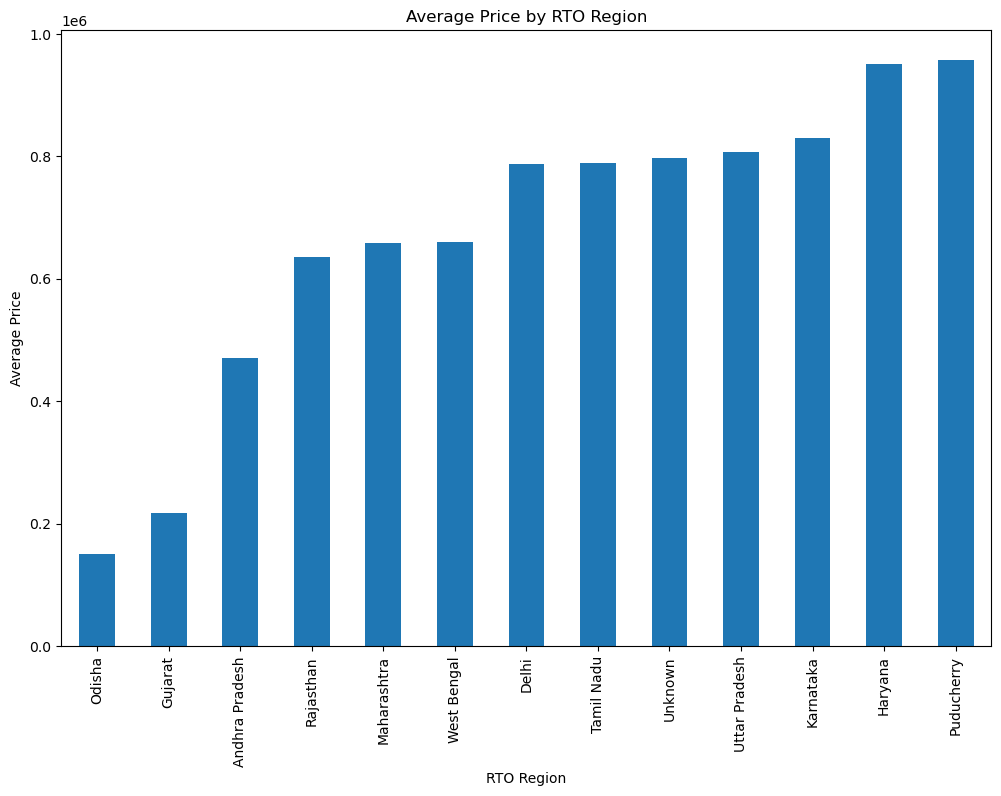

In [56]:
# Plotting average car price by RTO region
plt.figure(figsize=(12, 8))  # Set figure size
average_prices = df_outliers_removed.groupby('RTO_region')['price'].mean().sort_values()  # Calculate average price by RTO region
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Price by RTO Region')  # Add a title
plt.xlabel('RTO Region')  # Label for the x-axis
plt.ylabel('Average Price')  # Label for the y-axis
plt.show()  # Display the plot


Color
Others                   1939
White                    1395
Silver                   1170
Red                       751
Blue                      537
                         ... 
Other                       1
O Purple                    1
Arctic Silver               1
Modern Steel Metallic       1
Light Orange                1
Name: count, Length: 143, dtype: int64
0


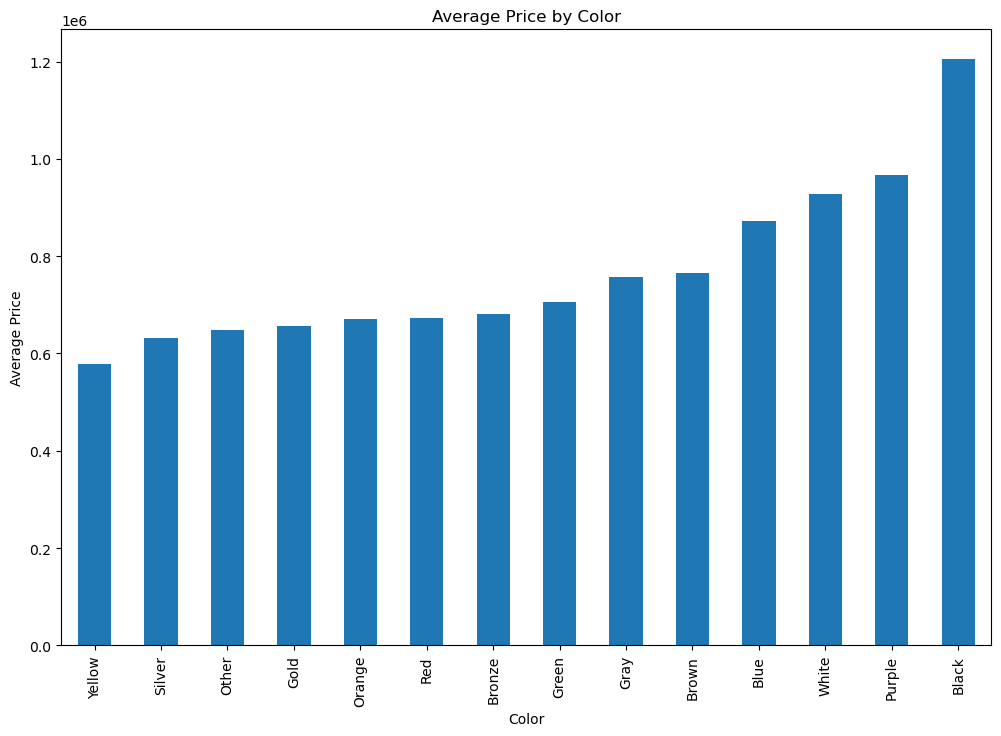

In [58]:
# Display the count of unique values in the 'Color' column
print(df_outliers_removed['Color'].value_counts())

# Check for missing values in the 'Color' column
print(df_outliers_removed['Color'].isna().sum())

# Function to standardize and group color values
def determine_color(color):
    color_lower = color.lower()
    
    if 'white' in color_lower:
        return 'White'
    elif 'red' in color_lower or 'wine' in color_lower or 'cherry' in color_lower:
        return 'Red'
    elif 'blue' in color_lower:
        return 'Blue'
    elif 'brown' in color_lower:
        return 'Brown'
    elif 'gold' in color_lower:
        return 'Gold'
    elif 'green' in color_lower:
        return 'Green'
    elif 'black' in color_lower:
        return 'Black'     
    elif 'orange' in color_lower:
        return 'Orange'
    elif 'yellow' in color_lower:
        return 'Yellow'
    elif 'bronze' in color_lower:
        return 'Bronze'
    elif 'purple' in color_lower:
        return 'Purple'
    elif 'grey' in color_lower or 'gray' in color_lower:
        return 'Gray'
    elif 'silver' in color_lower or 'metal' in color_lower or 'steel' in color_lower:
        return 'Silver'
    else:
        return 'Other'  # Group uncommon colors as 'Other'

# Apply the color grouping function to the 'Color' column
df_outliers_removed['Color'] = df_outliers_removed['Color'].apply(determine_color)

# Display the updated count of unique values in the 'Color' column
df_outliers_removed['Color'].value_counts()

# Plotting average car price by color
plt.figure(figsize=(12, 8))  # Set figure size
average_prices = df_outliers_removed.groupby('Color')['price'].mean().sort_values()  # Calculate average price by color
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Price by Color')  # Add a title
plt.xlabel('Color')  # Label for x-axis
plt.ylabel('Average Price')  # Label for y-axis
plt.show()  # Display the plot


In [60]:
# Display the count of unique values in the 'Engine Type' column
df_outliers_removed['Engine Type'].value_counts()

# Too many categories in 'Engine Type', and we already have 'engine displacement' and 'fuel type', so we drop 'Engine Type'
df_outliers_removed.drop(['Engine Type'], axis=1, inplace=True)

# Display the count of unique values in the 'Fuel Supply System' column
df_outliers_removed['Fuel Suppy System'].value_counts()


Fuel Suppy System
MPFI                                  1959
MPFi                                   797
CRDi                                   748
CRDI                                   715
Direct Injection                       595
PGM-Fi                                 199
PGM - Fi                               155
GDi                                    111
Common Rail                             68
EFI                                     64
EFI(Electronic Fuel Injection)          61
TSI                                     56
MPI                                     47
MPi                                     38
PGM-FI (Programmed Fuel Injection)      37
SEFI                                    33
MPFI                                    33
EFI (Electronic Fuel Injection)         26
Direct Injection                        25
Electronic Injection System             15
PGM-FI                                  13
Multi-point injection                   11
TDCi                                

In [62]:
# Drop the 'Fuel Supply System' column as it is not necessary
df_outliers_removed.drop(['Fuel Suppy System'], axis=1, inplace=True)


In [64]:
# Display the count of unique values in the 'Turbo Charger' column
print(df_outliers_removed['Turbo Charger'].value_counts())

# Check for missing values in the 'Turbo Charger' column
print(df_outliers_removed['Turbo Charger'].isna().sum())

# Display the count of unique values in the 'Super Charger' column
print('\n', df_outliers_removed['Super Charger'].value_counts())

# Check for missing values in the 'Super Charger' column
print(df_outliers_removed['Super Charger'].isna().sum())


Turbo Charger
No       3978
Yes      2440
Twin       21
NO         20
YES        15
no          8
Turbo       1
yes         1
Name: count, dtype: int64
911

 Super Charger
No     5695
Yes       6
NO        2
Name: count, dtype: int64
1692


C:\Users\Anton\AppData\Local\Temp\ipykernel_6400\1211590542.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_outliers_removed['Turbo Charger'] = df_outliers_removed['Turbo Charger'].map(mapping).fillna(False)


Turbo Charger
False    4917
True     2478
Name: count, dtype: int64
0


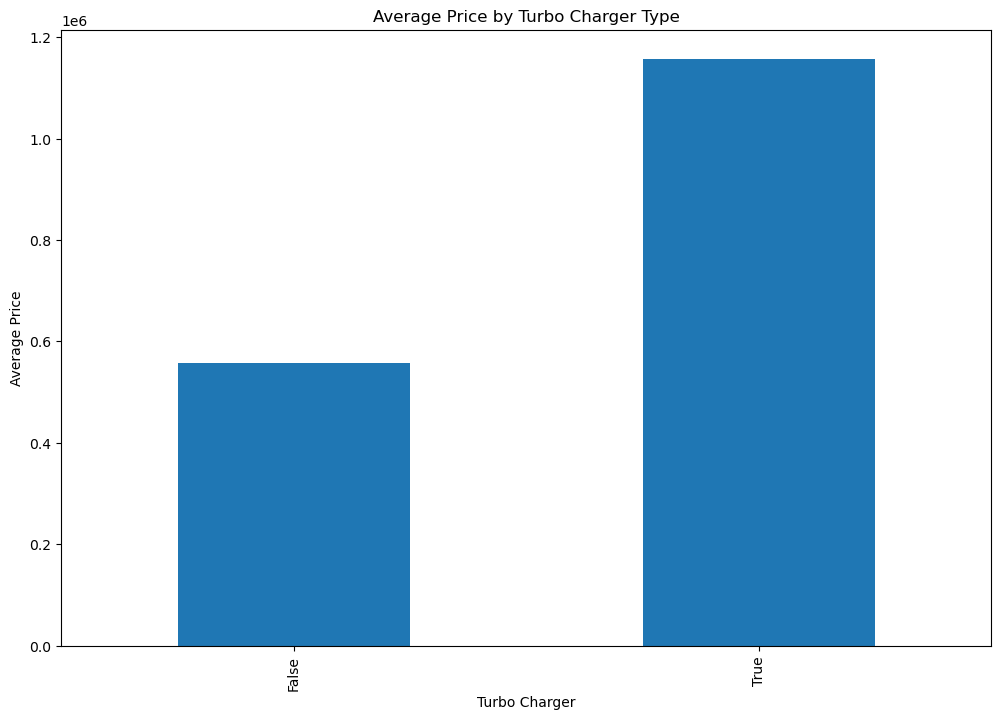

In [66]:
# Drop 'Super Charger' column since over 90% of values are 'No' and many are missing
df_outliers_removed.drop('Super Charger', axis=1, inplace=True)

# Convert 'Turbo Charger' values to boolean, filling missing values with False
mapping = {
    'No': False,
    'NO': False,
    'no': False,
    None: False,
    'Yes': True,
    'YES': True,
    'yes': True,
    'Turbo': True,
    'Twin': True
}
df_outliers_removed['Turbo Charger'] = df_outliers_removed['Turbo Charger'].map(mapping).fillna(False)

# Check the count of True/False values in 'Turbo Charger'
print(df_outliers_removed['Turbo Charger'].value_counts())

# Check for any remaining missing values in 'Turbo Charger'
print(df_outliers_removed['Turbo Charger'].isna().sum())

# Plot average car price by Turbo Charger type (True/False)
plt.figure(figsize=(12, 8))
average_prices = df_outliers_removed.groupby('Turbo Charger')['price'].mean().sort_values()  # Calculate average price by Turbo Charger type
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Price by Turbo Charger Type')  # Add a title
plt.xlabel('Turbo Charger')  # Label for x-axis
plt.ylabel('Average Price')  # Label for y-axis
plt.show()  # Display the plot


Drive Type
FWD                                  5183
RWD                                   301
2WD                                   117
AWD                                   109
4X2                                    67
2 WD                                   45
4X4                                    41
4WD                                    41
Front Wheel Drive                      38
FWD                                    34
4x2                                    15
Two Wheel Drive                        14
4x4                                    11
Rear Wheel Drive with ESP               6
All Wheel Drive                         2
Permanent all-wheel drive quattro       2
2WD                                     1
4 WD                                    1
Name: count, dtype: int64
1367


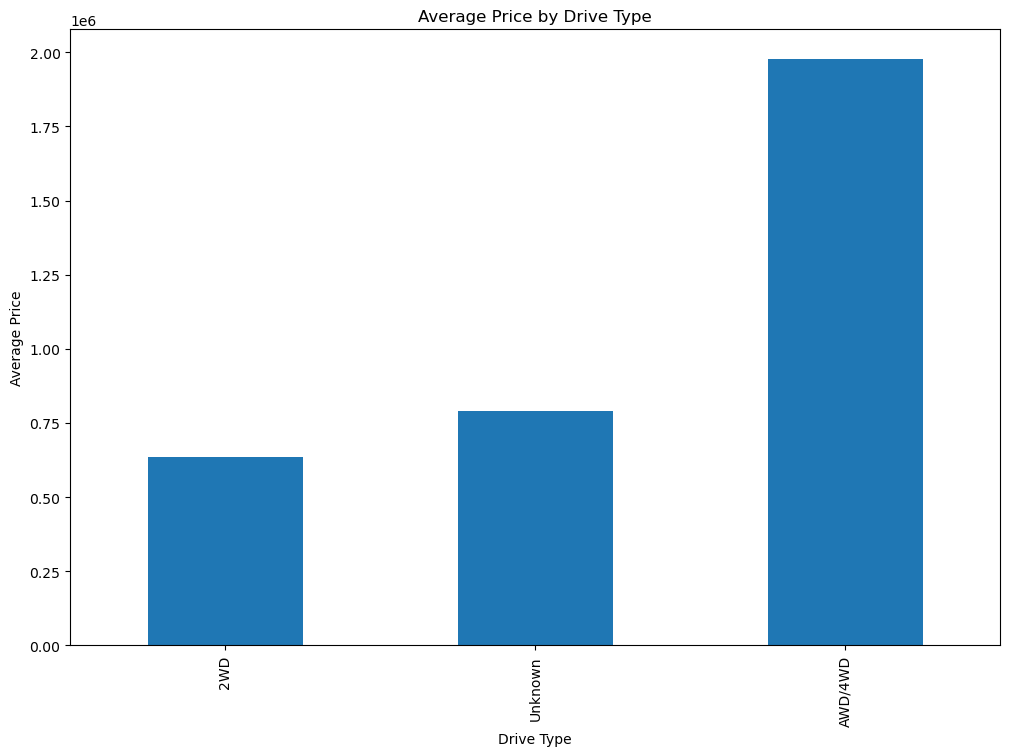

In [68]:
# Drop 'Gear Box' column as it's unnecessary due to Transmission and Fuel Type columns
df_outliers_removed.drop('Gear Box', axis=1, inplace=True)

# Display the count of unique values in the 'Drive Type' column
print(df_outliers_removed['Drive Type'].value_counts())

# Check for missing values in the 'Drive Type' column
print(df_outliers_removed['Drive Type'].isna().sum())

# Function to classify 'Drive Type' into categories: '2WD', 'AWD/4WD', and 'Unknown'
def classify_drive_type(drive):
    if isinstance(drive, str):  # Ensure it's a string
        drive = drive.lower()  # Convert to lowercase for uniformity
        if 'fwd' in drive or 'front' in drive or 'two wheel' in drive or '2wd' in drive:
            return '2WD'
        elif 'awd' in drive or '4wd' in drive or '4x4' in drive or 'rwd' in drive or 'rear' in drive:
            return 'AWD/4WD'
    return 'Unknown'  # Default to 'Unknown' for missing or unclassified values

# Apply the classification function to the 'Drive Type' column
df_outliers_removed['Drive_Type_Classified'] = df_outliers_removed['Drive Type'].apply(classify_drive_type)

# Display the count of classified drive types
df_outliers_removed['Drive_Type_Classified'].value_counts()

# Plot average car price by classified Drive Type
plt.figure(figsize=(12, 8))
average_prices = df_outliers_removed.groupby('Drive_Type_Classified')['price'].mean().sort_values()  # Calculate average price by Drive Type
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Price by Drive Type')  # Add a title
plt.xlabel('Drive Type')  # Label for x-axis
plt.ylabel('Average Price')  # Label for y-axis
plt.show()  # Display the plot


Steering Type
Power         5631
Electric      1320
Electronic     102
Manual          58
Electrical      39
power           29
EPAS             9
Name: count, dtype: int64
207


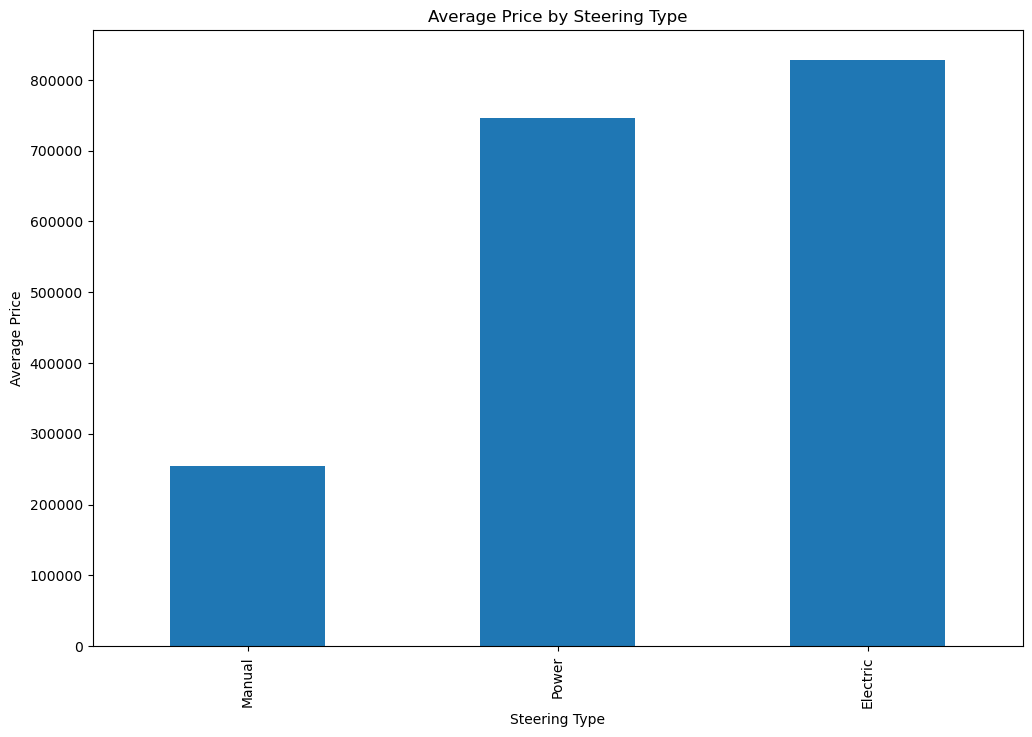

In [70]:
# Display the count of unique values in the 'Steering Type' column
print(df_outliers_removed['Steering Type'].value_counts())

# Check for missing values in the 'Steering Type' column
print(df_outliers_removed['Steering Type'].isna().sum())

# Function to classify 'Steering Type' into three categories: 'Power', 'Electric', and 'Manual'
def classify_steering_type(steering):
    if isinstance(steering, str):  # Ensure it's a string
        steering = steering.lower()  # Convert to lowercase for consistency
        if 'power' in steering:
            return 'Power'
        elif 'electric' in steering or 'epas' in steering or 'electronic' in steering:
            return 'Electric'
        elif 'manual' in steering:
            return 'Manual'
    # Default to 'Power' for missing or unclassified values
    return 'Power'

# Apply the classification function to the 'Steering Type' column
df_outliers_removed['Steering_Type_Classified'] = df_outliers_removed['Steering Type'].apply(classify_steering_type)

# Display the count of classified steering types
df_outliers_removed['Steering_Type_Classified'].value_counts()

# Plot average car price by classified Steering Type
plt.figure(figsize=(12, 8))
average_prices = df_outliers_removed.groupby('Steering_Type_Classified')['price'].mean().sort_values()  # Calculate average price by Steering Type
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Price by Steering Type')  # Add a title
plt.xlabel('Steering Type')  # Label for x-axis
plt.ylabel('Average Price')  # Label for y-axis
plt.show()  # Display the plot


In [72]:
# Power and Electric steering types show similar behavior, and rows with 'Manual' are significantly fewer.
# Therefore, we drop the 'Steering_Type_Classified' and 'Steering Type' columns.
df_outliers_removed.drop(['Steering_Type_Classified', 'Steering Type'], axis=1, inplace=True)


In [74]:
# Display the count of unique values in the 'Front Brake Type' column
print(df_outliers_removed['Front Brake Type'].value_counts())

# Display the count of unique values in the 'Rear Brake Type' column
print('\n', df_outliers_removed['Rear Brake Type'].value_counts())


Front Brake Type
Disc                                        4834
Ventilated Disc                             2176
Disc                                          70
Solid Disc                                    63
Ventilated Discs                              50
Disc & Caliper Type                           40
Disk                                          23
Ventilated Disc                               23
Ventilated Disk                               11
disc                                           7
Ventilated discs                               6
Drum                                           6
 Disc                                          6
Multilateral Disc                              6
Ventlated Disc                                 6
Vantilated Disc                                5
Ventilated DIsc                                5
Ventillated Disc                               3
 Ventilated Disc                               2
Vacuum assisted hydraulic dual circuit w       2
Ven

In [76]:
# The 'Steering Type' has too many categories and little impact on price, so it has been removed.
# 'Drum' and 'ABS' are rare, while 'Disc' dominates, so 'Front Brake Type' and 'Rear Brake Type' are also removed.
df_outliers_removed.drop(['Front Brake Type', 'Rear Brake Type'], axis=1, inplace=True)

# Display the count of unique values in the 'Tyre Type' column
df_outliers_removed['Tyre Type'].value_counts()


Tyre Type
Tubeless,Radial           3811
Tubeless, Radial          1318
Tubeless                  1117
Tubeless Tyres             391
Radial, Tubeless           216
Radial                     117
Radial, Tubless             82
Tubeless Tyres, Radial      54
Tubeless Radial Tyres       50
Tubeless,Radial             50
Radial,Tubeless             31
Tubeless,Radials            27
Tubless, Radial             24
tubeless tyre               14
Runflat                     12
Run-Flat                    12
Tubeless, Runflat            7
Tubeless                     7
Radial Tubeless              4
Tubeless Radials Tyre        3
Tubeless,Runflat             3
Tubeless Tyre                2
Runflat Tyres                2
Radial Tyres                 1
Tubeless, Radials            1
Name: count, dtype: int64

In [78]:
# Most of the rows in 'Tyre Type' have similar values (Tubeless or Radical), so we can drop this column.
df_outliers_removed.drop(['Tyre Type'], axis=1, inplace=True)

# Display the count of unique values in the 'Location' column
df_outliers_removed['Location'].value_counts()


Location
Hyderabad    1338
Bangalore    1307
Chennai      1276
Delhi        1241
Kolkata      1240
Jaipur        993
Name: count, dtype: int64

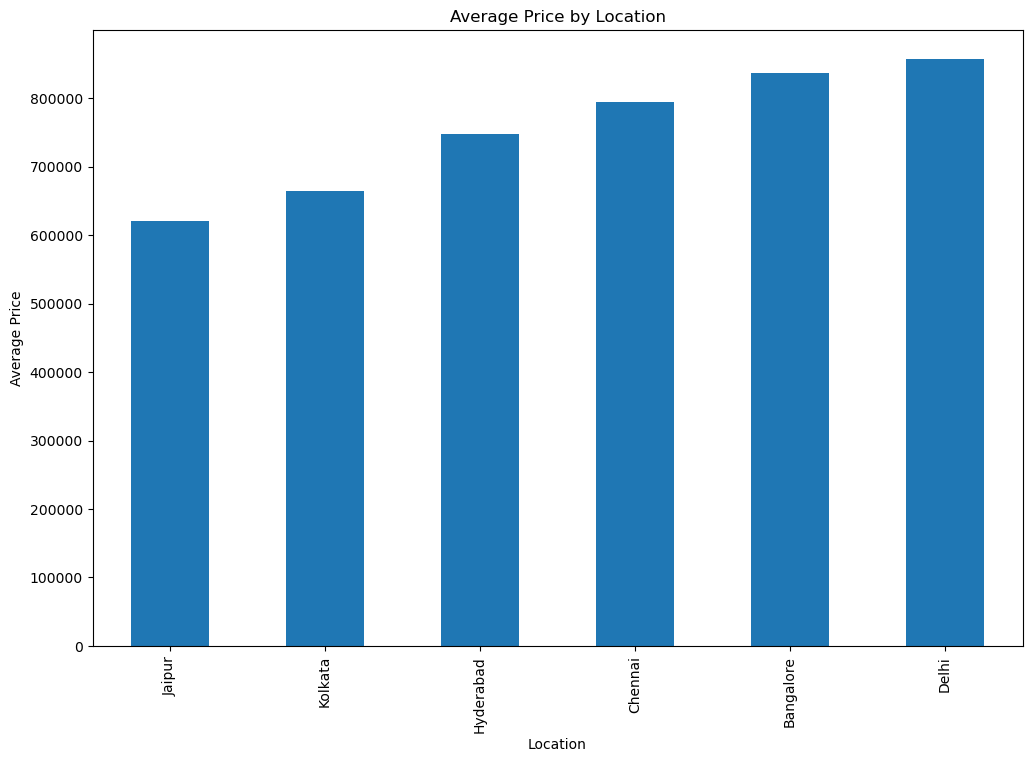

In [80]:
# The 'Location' column was added based on the Excel files.
# Let's analyze the relationship between location and the average price.
plt.figure(figsize=(12, 8))  # Set figure size
average_prices = df_outliers_removed.groupby('Location')['price'].mean().sort_values()  # Calculate average price by location
average_prices.plot(kind='bar')  # Plot the data as a bar chart
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Average Price by Location')  # Add a title
plt.xlabel('Location')  # Label for x-axis
plt.ylabel('Average Price')  # Label for y-axis
plt.show()  # Display the plot


In [82]:
# Check for any remaining missing values in the DataFrame
df_outliers_removed.isna().sum()


ft                          0
bt                          0
km                          0
transmission                0
ownerNo                     0
company                     0
model                       0
modelYear                   0
price                       0
Insurance Validity          0
Mileage                     0
Color                       0
Displacement                0
Turbo Charger               0
Drive Type               1367
Location                    0
RTO_region                  0
Drive_Type_Classified       0
dtype: int64

In [84]:
# Drop the old 'Drive Type' column as we now have the classified 'Drive_Type_Classified'
df_outliers_removed.drop(['Drive Type'], axis=1, inplace=True)
# Check for any remaining missing values in the DataFrame
df_outliers_removed.isna().sum()


ft                       0
bt                       0
km                       0
transmission             0
ownerNo                  0
company                  0
model                    0
modelYear                0
price                    0
Insurance Validity       0
Mileage                  0
Color                    0
Displacement             0
Turbo Charger            0
Location                 0
RTO_region               0
Drive_Type_Classified    0
dtype: int64

In [86]:
# Save the preprocessed DataFrame to an Excel file
df_outliers_removed.to_excel('Preprocessed_data.xlsx', index=False)

# Display the first row of the preprocessed DataFrame to verify the changes
df_outliers_removed.head(1)


,ft,bt,km,transmission,ownerNo,company,model,modelYear,price,Insurance Validity,Mileage,Color,Displacement,Turbo Charger,Location,RTO_region,Drive_Type_Classified
0,Petrol,Hatchback,20000.0,Automatic,1,Volkswagen,Volkswagen Polo,2022,1044000.0,Third Party insurance,16.47,Other,999.0,True,Hyderabad,Unknown,2WD


In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Load the dataset
df_cars = pd.read_excel('Preprocessed_data.xlsx')

# Identify categorical and numerical columns
cat_features = df_cars.select_dtypes(include=['object']).columns
num_features = df_cars.select_dtypes(include=['number']).columns

# Separate features (X) and target (y)
X = df_cars.drop('price', axis=1)
y = df_cars['price']

# Encode categorical features using one-hot encoding
X_encoded = pd.get_dummies(X, columns=cat_features, drop_first=True)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, shuffle=True)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Define models
regressors = {
    'Random Forest': RandomForestRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Linear Regression': LinearRegression()
}

# Store model performance results
performance_results = {}

# Loop through each model
for model_name, model in regressors.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions for training and testing sets
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Compute performance metrics
    metrics = {
        'Train MSE': mean_squared_error(y_train, train_preds),
        'Train MAE': mean_absolute_error(y_train, train_preds),
        'Train R2': r2_score(y_train, train_preds),
        'Train MAPE': mean_absolute_percentage_error(y_train, train_preds) * 100,
        'Test MSE': mean_squared_error(y_test, test_preds),
        'Test MAE': mean_absolute_error(y_test, test_preds),
        'Test R2': r2_score(y_test, test_preds),
        'Test MAPE': mean_absolute_percentage_error(y_test, test_preds) * 100
    }
    
    # Store metrics for each model
    performance_results[model_name] = metrics

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(performance_results).T

# Display model performance results
print(results_df)


Training data shape: (5916, 204)
Testing data shape: (1479, 204)
                            Train MSE      Train MAE  Train R2  Train MAPE  \
Random Forest            3.845621e+09   33348.187263  0.990519    5.107182   
XGBoost Regressor        5.147022e+09   48864.439211  0.987311    8.409458   
Decision Tree Regressor  1.646138e+08     650.101420  0.999594    0.059475   
Linear Regression        5.643059e+10  132322.425405  0.860877   24.712700   

                             Test MSE       Test MAE   Test R2  Test MAPE  
Random Forest            2.678936e+10   87312.925620  0.939393  13.109663  
XGBoost Regressor        2.391558e+10   82597.844905  0.945895  12.754370  
Decision Tree Regressor  4.270291e+10  114362.310345  0.903391  16.935927  
Linear Regression        6.386995e+10  141635.483921  0.855504  24.790534  


In [90]:
# The results indicate that Random Forest and XGBoost Regressor are the best-performing models overall.
# Both models have high R² values and relatively low MSE and MAE on the test set, suggesting good performance.

# Random Forest:
# - Train MSE: 3.85e+09 | Test MSE: 2.68e+10
# - Train MAE: 33,348 | Test MAE: 87,312
# - Train R²: 0.990 | Test R²: 0.939
# - Test MAPE: 13.11% -> This model generalizes well.

# XGBoost Regressor:
# - Train MSE: 5.15e+09 | Test MSE: 2.39e+10
# - Train MAE: 48,864 | Test MAE: 82,597
# - Train R²: 0.987 | Test R²: 0.946
# - Test MAPE: 12.75% -> Similar to Random Forest, performs well on both train and test data.

# Decision Tree Regressor:
# - Train MSE: 1.65e+08 (very low) | Test MSE: 4.27e+10 (high)
# - Train MAE: 650 | Test MAE: 114,362
# - Train R²: 0.999 (overfit) | Test R²: 0.903 (much lower than on training data)
# - Test MAPE: 16.94% -> This model is likely overfitting the training data.

# Linear Regression:
# - Train MSE: 5.64e+10 | Test MSE: 6.39e+10
# - Train MAE: 132,322 | Test MAE: 141,635
# - Train R²: 0.861 | Test R²: 0.856
# - Test MAPE: 24.79% -> Linear Regression struggles with the complexity of the dataset, performing the worst.

# Summary:
# - Random Forest and XGBoost Regressor are performing the best, with low errors and high R² on both train and test sets.
# - Decision Tree Regressor shows signs of overfitting, performing much better on training data than on the test set.
# - Linear Regression has the highest errors and is not recommended for this dataset.

# Next steps could include hyperparameter tuning for Random Forest and XGBoost or cross-validation to further validate the results.


In [92]:
# Random Forest: Hyperparameter tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Hyperparameter tuning using RandomizedSearchCV with 5-fold cross-validation
rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of random parameter samples to try
    scoring='neg_mean_absolute_percentage_error',  # Evaluation metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Print detailed progress
    random_state=42  # Ensure reproducibility
)

# Fit RandomizedSearchCV to the training data
rf_random_search.fit(X_train, y_train)

# Get the best parameters from the search
best_rf_params = rf_random_search.best_params_
print(f"Best Random Forest Parameters: {best_rf_params}")

# Initialize Random Forest with the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    bootstrap=best_rf_params['bootstrap'],
    random_state=42
)

# Train the optimized Random Forest model on the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = best_rf_model.predict(X_train)

# Calculate metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100

# Print training metrics
print(f"Training Metrics:")
print(f"MSE: {train_mse}")
print(f"MAE: {train_mae}")
print(f"R^2: {train_r2}")
print(f"MAPE: {train_mape}%")

# Make predictions on the test set
y_test_pred = best_rf_model.predict(X_test)

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

# Print test metrics
print(f"\nTest Metrics:")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"R^2: {test_r2}")
print(f"MAPE: {test_mape}%")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Anton\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
260 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
131 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Anton\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Anton\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Anton\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_const

Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Training Metrics:
MSE: 14700690407.972422
MAE: 66435.73173689774
R^2: 0.9637571433592164
MAPE: 11.08760533726412%

Test Metrics:
MSE: 40189871925.04136
MAE: 104016.60857614293
R^2: 0.9090763757328033
MAPE: 17.54199232901601%


In [94]:
# XGBoost: Hyperparameter tuning using RandomizedSearchCV
xgb_model = XGBRegressor(random_state=42)

# Define the hyperparameter grid for RandomizedSearchCV
param_distributions_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform RandomizedSearchCV with 5-fold cross-validation
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=50,  # Number of random parameter samples to try
    scoring='neg_mean_absolute_percentage_error',  # Evaluation metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Print progress
    random_state=42  # Ensure reproducibility
)

# Fit the model
xgb_random_search.fit(X_train, y_train)

# Get the best parameters from the search
best_xgb_params = xgb_random_search.best_params_
print(f"Best XGBoost Parameters: {best_xgb_params}")

# Initialize XGBoost with the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=best_xgb_params['n_estimators'],
    max_depth=best_xgb_params['max_depth'],
    learning_rate=best_xgb_params['learning_rate'],
    subsample=best_xgb_params['subsample'],
    colsample_bytree=best_xgb_params['colsample_bytree'],
    random_state=42
)

# Train the optimized XGBoost model on the training data
best_xgb_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_xgb = best_xgb_model.predict(X_train)

# Calculate metrics for the training set
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
mape_train_xgb = mean_absolute_percentage_error(y_train, y_train_pred_xgb) * 100

# Print training metrics
print(f"XGBoost Training Metrics:")
print(f"MSE: {mse_train_xgb}")
print(f"MAE: {mae_train_xgb}")
print(f"R^2: {r2_train_xgb}")
print(f"MAPE: {mape_train_xgb}%")

# Make predictions on the test set
y_test_pred_xgb = best_xgb_model.predict(X_test)

# Calculate metrics for the test set
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)
mape_test_xgb = mean_absolute_percentage_error(y_test, y_test_pred_xgb) * 100

# Print test metrics
print(f"XGBoost Test Metrics:")
print(f"MSE: {mse_test_xgb}")
print(f"MAE: {mae_test_xgb}")
print(f"R^2: {r2_test_xgb}")
print(f"MAPE: {mape_test_xgb}%")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
XGBoost Training Metrics:
MSE: 1750987949.3361058
MAE: 29122.373435783258
R^2: 0.9956831411677705
MAPE: 5.475507488645241%
XGBoost Test Metrics:
MSE: 23950352784.79546
MAE: 79072.51004954784
R^2: 0.9458158791415628
MAPE: 11.83996926562325%


In [96]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Define Ridge and Lasso regression models
models = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
}

# Store the results for comparison
results = {}

# Evaluate each model in the dictionary
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics for the training set
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    
    # Calculate performance metrics for the test set
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Store the results in a dictionary
    results[model_name] = {
        'MSE_train': mse_train,
        'MAE_train': mae_train,
        'R2_train': r2_train,
        'MAPE_train': mape_train,
        'MSE_test': mse_test,
        'MAE_test': mae_test,
        'R2_test': r2_test,
        'MAPE_test': mape_test
    }

# Convert the results dictionary to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T

# Display the results
print(results_df)


                     MSE_train      MAE_train  R2_train  MAPE_train  \
Ridge Regression  5.735454e+10  134379.560801  0.858599   25.159768   
Lasso Regression  5.644449e+10  132405.906892  0.860843   24.734344   

                      MSE_test       MAE_test   R2_test  MAPE_test  
Ridge Regression  6.413396e+10  144193.177624  0.854906  25.167451  
Lasso Regression  6.387443e+10  141719.520932  0.855494  24.795948  


C:\Users\Anton\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e+14, tolerance: 2.400e+11
  model = cd_fast.enet_coordinate_descent(


In [98]:
import joblib

# Save the trained XGBoost model to a file
joblib.dump(best_xgb_model, 'xgboost_ml_model.pkl')

# Save the list of encoded column names for future reference (e.g., during model deployment)
encoded_columns = list(X_encoded.columns)
joblib.dump(encoded_columns, 'encoded_columns.pkl')


['encoded_columns.pkl']